In [1]:
import sys
sys.path.append("..")

import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, jit, vmap
import numpyro
from numpyro import distributions as dist
from numpyro import infer

from numpyro_ext import distributions as distx
from numpyro_ext import info, optim

jax.config.update("jax_enable_x64", True)
numpyro.set_host_device_count(2)
#jax.config.update('jax_disable_jit', True)

from jaxoplanet import light_curves, orbits
from jaxoplanet.light_curves import limb_dark_light_curve
import arviz as az
import corner

from core.jax import oblate_lightcurve, compute_bounds

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


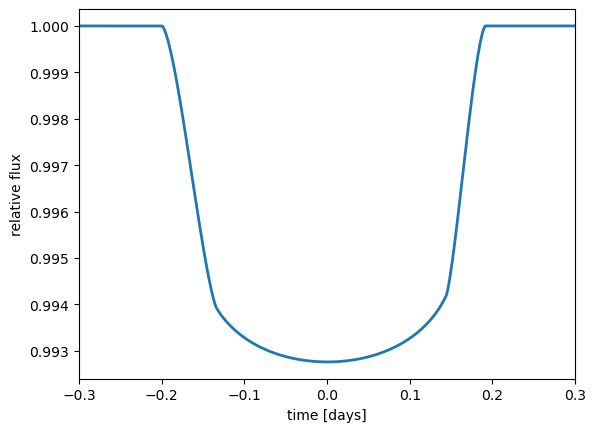

In [2]:
#Fiducial planet parameters:
params = {'period':300.456,
          'radius':0.1,
          'u':jnp.array([0.3,0.2]),
          'f':0.3,
          'bo':0.7,
          'theta':jnp.radians(35),
          'duration': 0.4
}
# The light curve calculation requires an orbit

# Compute a limb-darkened light curve using starry
t = jnp.linspace(-0.3, 0.3, 1000)
oblate_lightcurve = jit(oblate_lightcurve)
lc = oblate_lightcurve(params,t)

plt.plot(t, lc, color="C0", lw=2)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
_ = plt.xlim(t.min(), t.max())

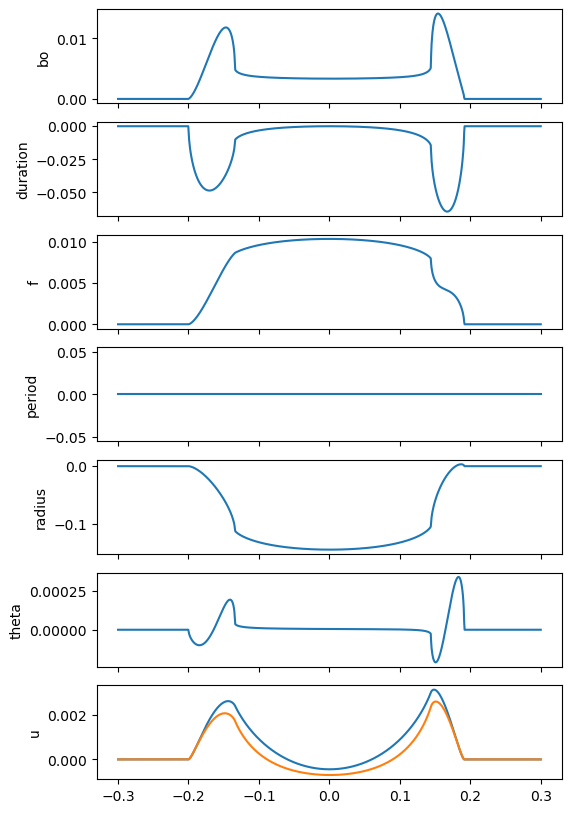

In [3]:
grad = jax.jacfwd(oblate_lightcurve)
grads = grad(params, t)
_, axes = plt.subplots(len(grads.keys()), 1, figsize=(6, 10), sharex=True)
for n, key in enumerate(grads.keys()):
    axes[n].plot(t, grads[key])
    axes[n].set_ylabel(key)

{'period': 7.704045333151538, 't0': 1.0, 'radius': 0.1, 'bo': 0.8, 'u': Array([0.3, 0.2], dtype=float64), 'f': 0.3, 'theta': 0.6108652381980153, 'duration': 0.12}


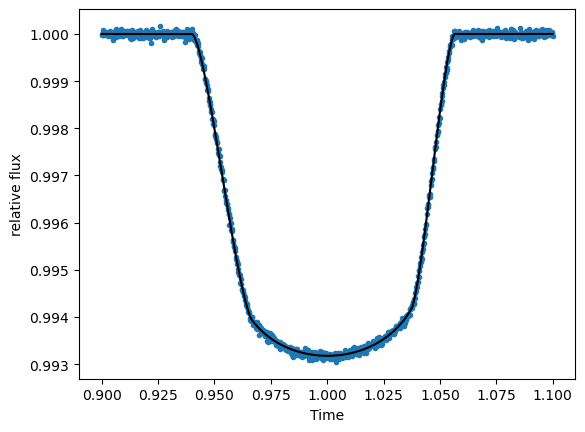

In [4]:
np.random.seed(11)
period_true = np.random.uniform(5, 20)
t = np.linspace(0.9,1.1,1000)
yerr = 50*1e-6

true_params = {'period':period_true,
               't0':1.0,
                'radius':0.1,
                'bo':0.8,
                'u':jnp.array([0.3, 0.2]),
                'f':0.3,
                'theta':np.radians(35),
                'duration': 0.12
} 

print(true_params)

# Compute a limb-darkened light curve using starry
lc_true = oblate_lightcurve(true_params, t-true_params['t0'])

lc = lc_true + yerr*np.random.normal(size=len(t))

ax = plt.subplot()
ax.plot(t, lc, 'C0.')
ax.plot(t, lc_true, color='k')
ax.set_ylabel("relative flux")
ax.set_xlabel("Time");

In [20]:
def model(t, yerr, y=None):
    # If we wanted to fit for all the parameters, we could use the following,
    # but we'll keep these fixed for simplicity.
    
    #log_duration = numpyro.sample("log_duration", dist.Uniform(jnp.log(0.08), jnp.log(0.2)))
    #b = numpyro.sample("b", dist.Uniform(0.0, 1.0))

    #log_jitter = numpyro.sample("log_jitter", dist.Normal(jnp.log(yerr), 1.0))
    r = numpyro.sample("r", dist.Uniform(0.01, 0.2))
    u = numpyro.sample("u", distx.QuadLDParams())
    bo = numpyro.sample("bo", dist.Uniform(0.0,1.))
    
    #parametrize f, theta using a unit disk
    hk = numpyro.sample("hk", distx.UnitDisk())
    f = numpyro.deterministic("f", hk[0] ** 2 + hk[1] ** 2)
    theta = numpyro.deterministic("theta", jnp.arctan2(hk[1], hk[0])/2)
    
    # The duration
    log_d = numpyro.sample("log_d", numpyro.distributions.Normal(jnp.log(0.12), 0.1))
    duration = numpyro.deterministic("duration", jnp.exp(log_d))
    
    params = {
        'period':period_true,
        't0': 1.0,
        "radius": r,
        'bo':bo,
        'u': u,
        'f':f, 
        'theta':theta,
        'duration': duration
    }
    y_pred = oblate_lightcurve(params, t-params['t0'])
    numpyro.deterministic("light_curve", y_pred)
    numpyro.sample(
        "flux",
        dist.Normal(y_pred, jnp.sqrt(yerr**2) #+ jnp.exp(2 * log_jitter))
                    ),
        obs=y,
    )

In [21]:
n_prior_samples = 3000
prior_samples = numpyro.infer.Predictive(model, num_samples=n_prior_samples)(
    jax.random.PRNGKey(0), t, yerr
)

# Let's make it into an arviz InferenceData object.
# To do so we'll first need to reshape the samples to be of shape (chains, draws, *shape)
converted_prior_samples = {
    f"{p}": np.expand_dims(prior_samples[p], axis=0) for p in prior_samples
}
prior_samples_inf_data = az.from_dict(converted_prior_samples)

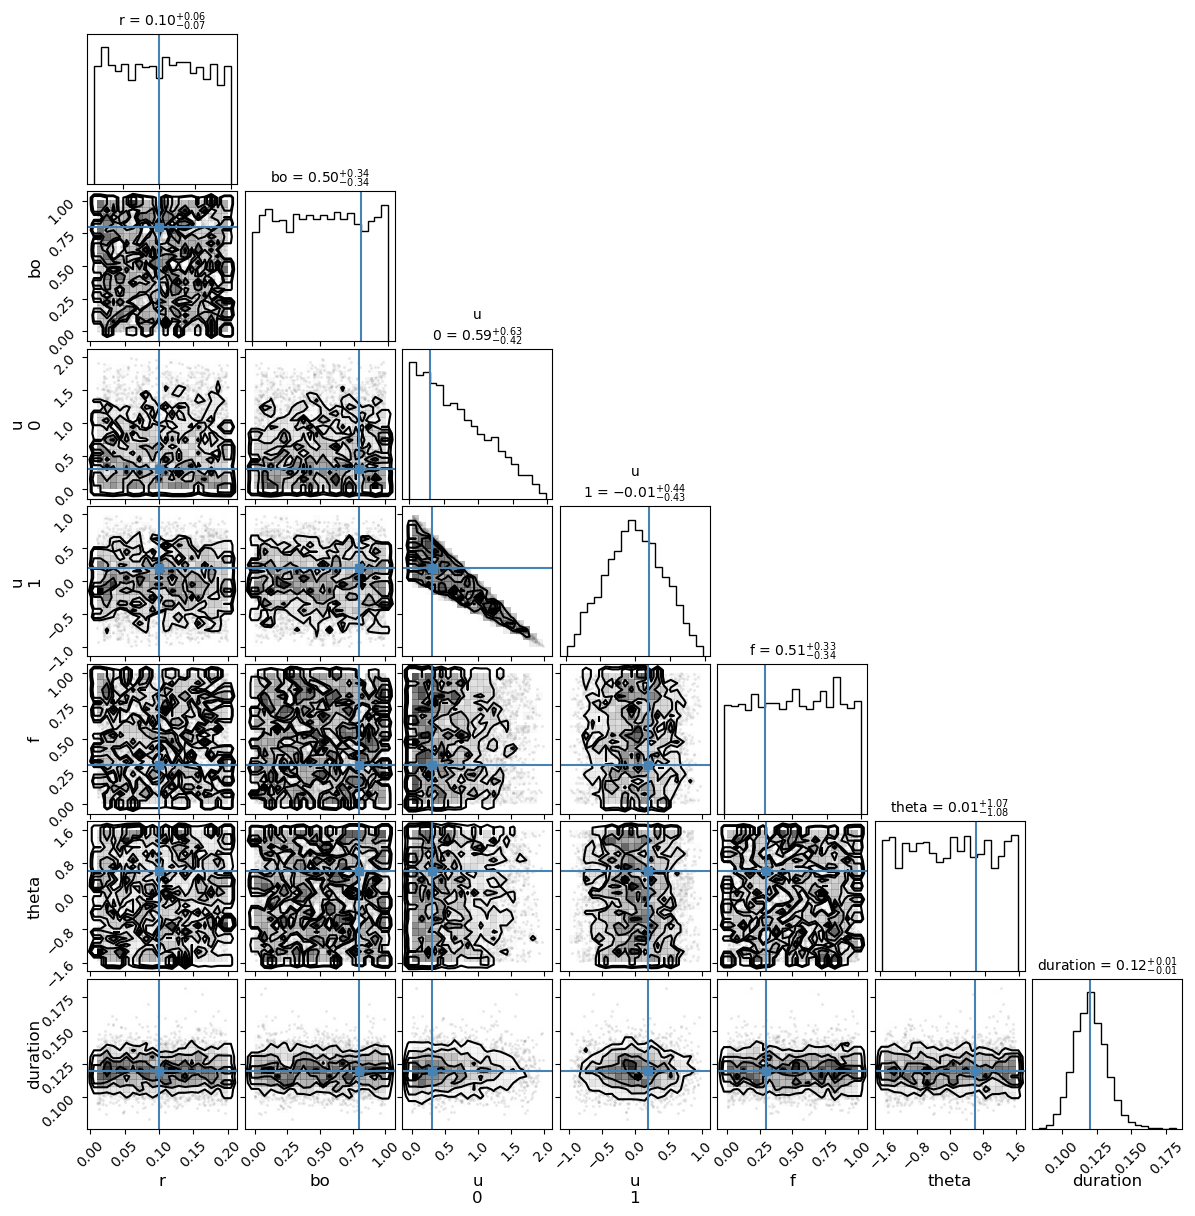

In [22]:
# Plot the corner plot
fig = plt.figure(figsize=(12, 12))
_ = corner.corner(
    prior_samples_inf_data,
    fig=fig,
    var_names=['r', 'bo', 'u', 'f', 'theta', 'duration'],
    truths=[true_params['radius'], true_params['bo'], true_params['u'][0], true_params['u'][1], true_params['f'], true_params['theta'], true_params['duration']],
    show_titles=True,
    title_kwargs={"fontsize": 10},
    label_kwargs={"fontsize": 12},
)

### Oblate MCMC Fit

In [26]:
init_params = {'period':period_true,
                't0':1.0,
                'log_jitter':np.log(yerr),
                'r':true_params['radius'],
                'u':jnp.array([0.3, 0.2]),
                'f':0.1,
                'bo':0.79,
                'theta':jnp.radians(20),
                'log_d': jnp.log(0.12),
                'hk':jnp.array([jnp.sqrt(0.1)*jnp.sin(jnp.radians(20)), jnp.sqrt(0.1)*jnp.cos(jnp.radians(20))])
               
}

In [27]:
import numpyro_ext.distributions, numpyro_ext.optim

run_optim = numpyro_ext.optim.optimize(
        model,
        init_strategy=numpyro.infer.init_to_value(values=init_params),
    )

opt_params = run_optim(jax.random.PRNGKey(5), t, yerr, y=lc)

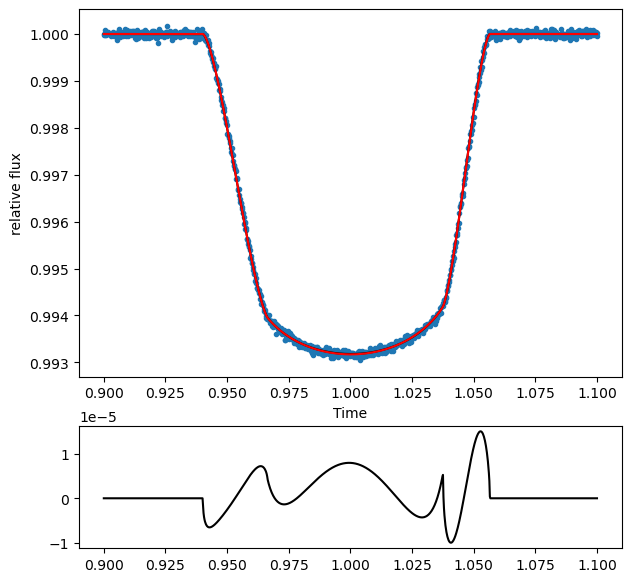

In [28]:
fig, (ax, ax1) = plt.subplots(2,1,figsize=(7,7), gridspec_kw={'height_ratios': [3, 1]})
ax.plot(t, lc, 'C0.')
ax.plot(t, lc_true, color='k')
ax.plot(t,opt_params['light_curve'], color='r')
ax1.plot(t, lc_true-opt_params['light_curve'], 'k-')
ax.set_ylabel("relative flux")
ax.set_xlabel("Time");

In [29]:
sampler_wn = infer.MCMC(
    infer.NUTS(
        model,
        target_accept_prob=0.9,
        dense_mass=True,
        init_strategy=infer.init_to_value(values=opt_params),
        regularize_mass_matrix=False,
    ),
    num_warmup=1000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)
%time sampler_wn.run(jax.random.PRNGKey(11), t, yerr, lc)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

CPU times: user 5h 56min 36s, sys: 46.7 s, total: 5h 57min 23s
Wall time: 4h 23min 51s


In [30]:
inf_data_wn = az.from_numpyro(sampler_wn)
az.summary(inf_data_wn, var_names=['r', 'bo', 'u', 'f', 'theta', 'duration'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r,0.100,0.000,0.099,0.101,0.000,0.000,4.0,44.0,1.47
bo,0.800,0.001,0.798,0.802,0.000,0.000,11.0,29.0,1.14
u[0],0.379,0.048,0.262,0.447,0.025,0.020,4.0,13.0,1.48
u[1],0.116,0.054,0.026,0.231,0.028,0.023,4.0,13.0,1.47
f,0.292,0.005,0.284,0.302,0.002,0.001,9.0,76.0,1.21
theta,0.595,0.018,0.574,0.615,0.013,0.011,3.0,145.0,1.86
duration,0.120,0.000,0.120,0.120,0.000,0.000,6.0,19.0,1.27


In [31]:
sampler_wn.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        bo      0.80      0.00      0.80      0.80      0.80      8.04      1.15
     hk[0]      0.20      0.02      0.20      0.18      0.22      1.01     10.59
     hk[1]      0.50      0.01      0.50      0.49      0.51      1.28      2.01
     log_d     -2.12      0.00     -2.12     -2.12     -2.12      3.59      1.28
         r      0.10      0.00      0.10      0.10      0.10      2.02      1.52
      u[0]      0.38      0.05      0.39      0.27      0.43      7.38      1.55
      u[1]      0.12      0.05      0.10      0.06      0.23      7.39      1.55

Number of divergences: 3961


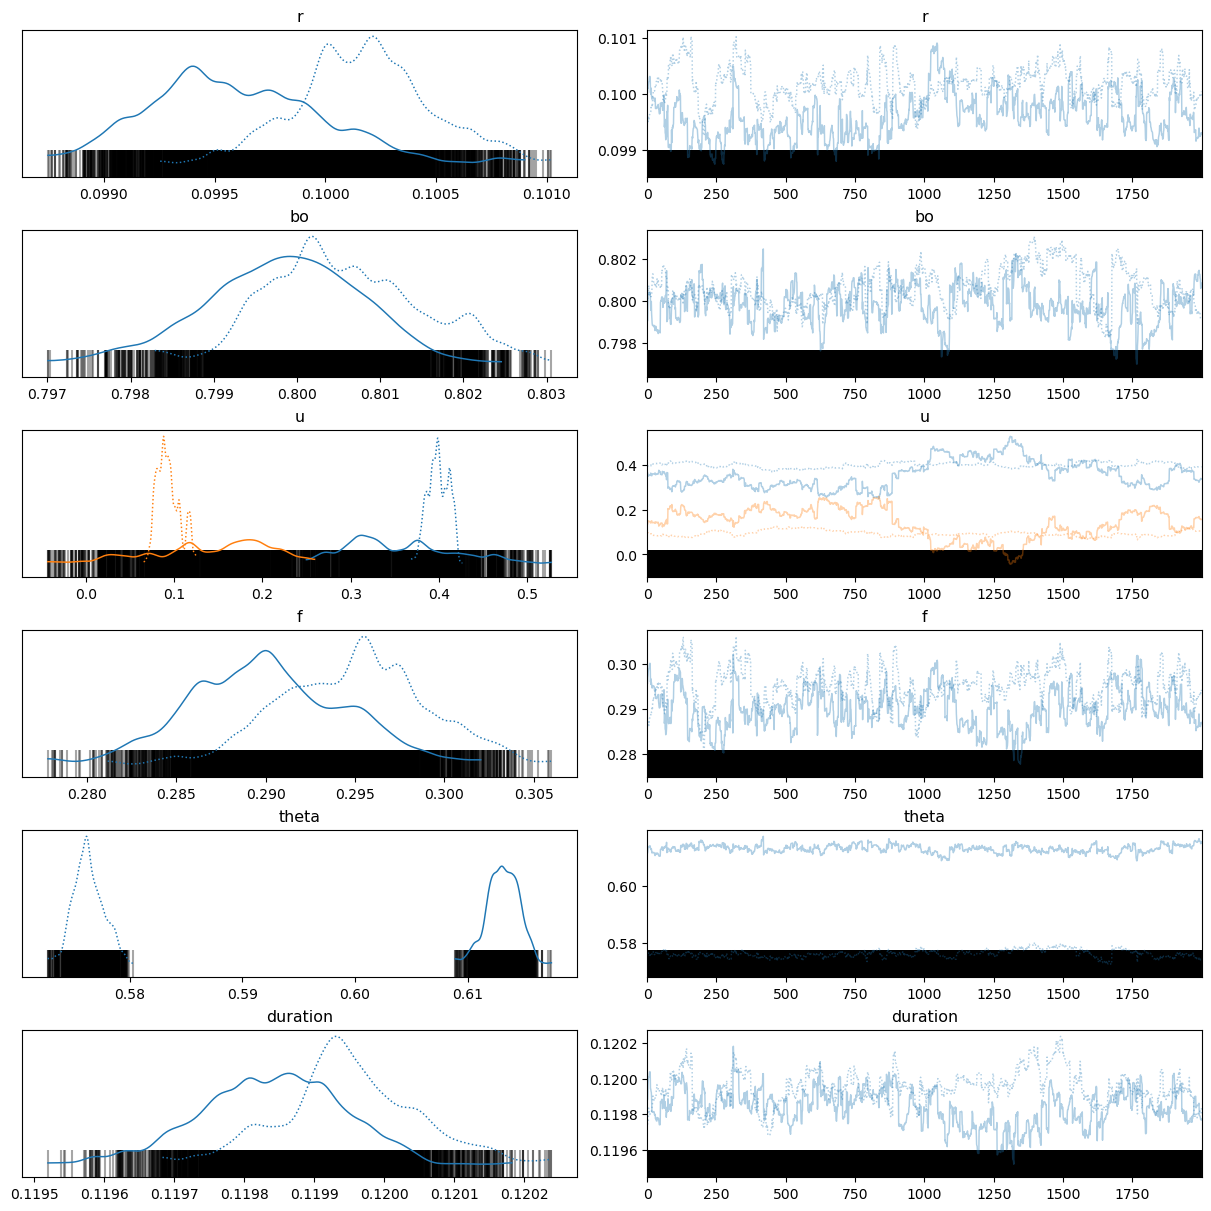

In [32]:
az.plot_trace(
    inf_data_wn,
    var_names=['r', 'bo', 'u', 'f', 'theta', 'duration'],
    backend_kwargs={"constrained_layout": True},
);

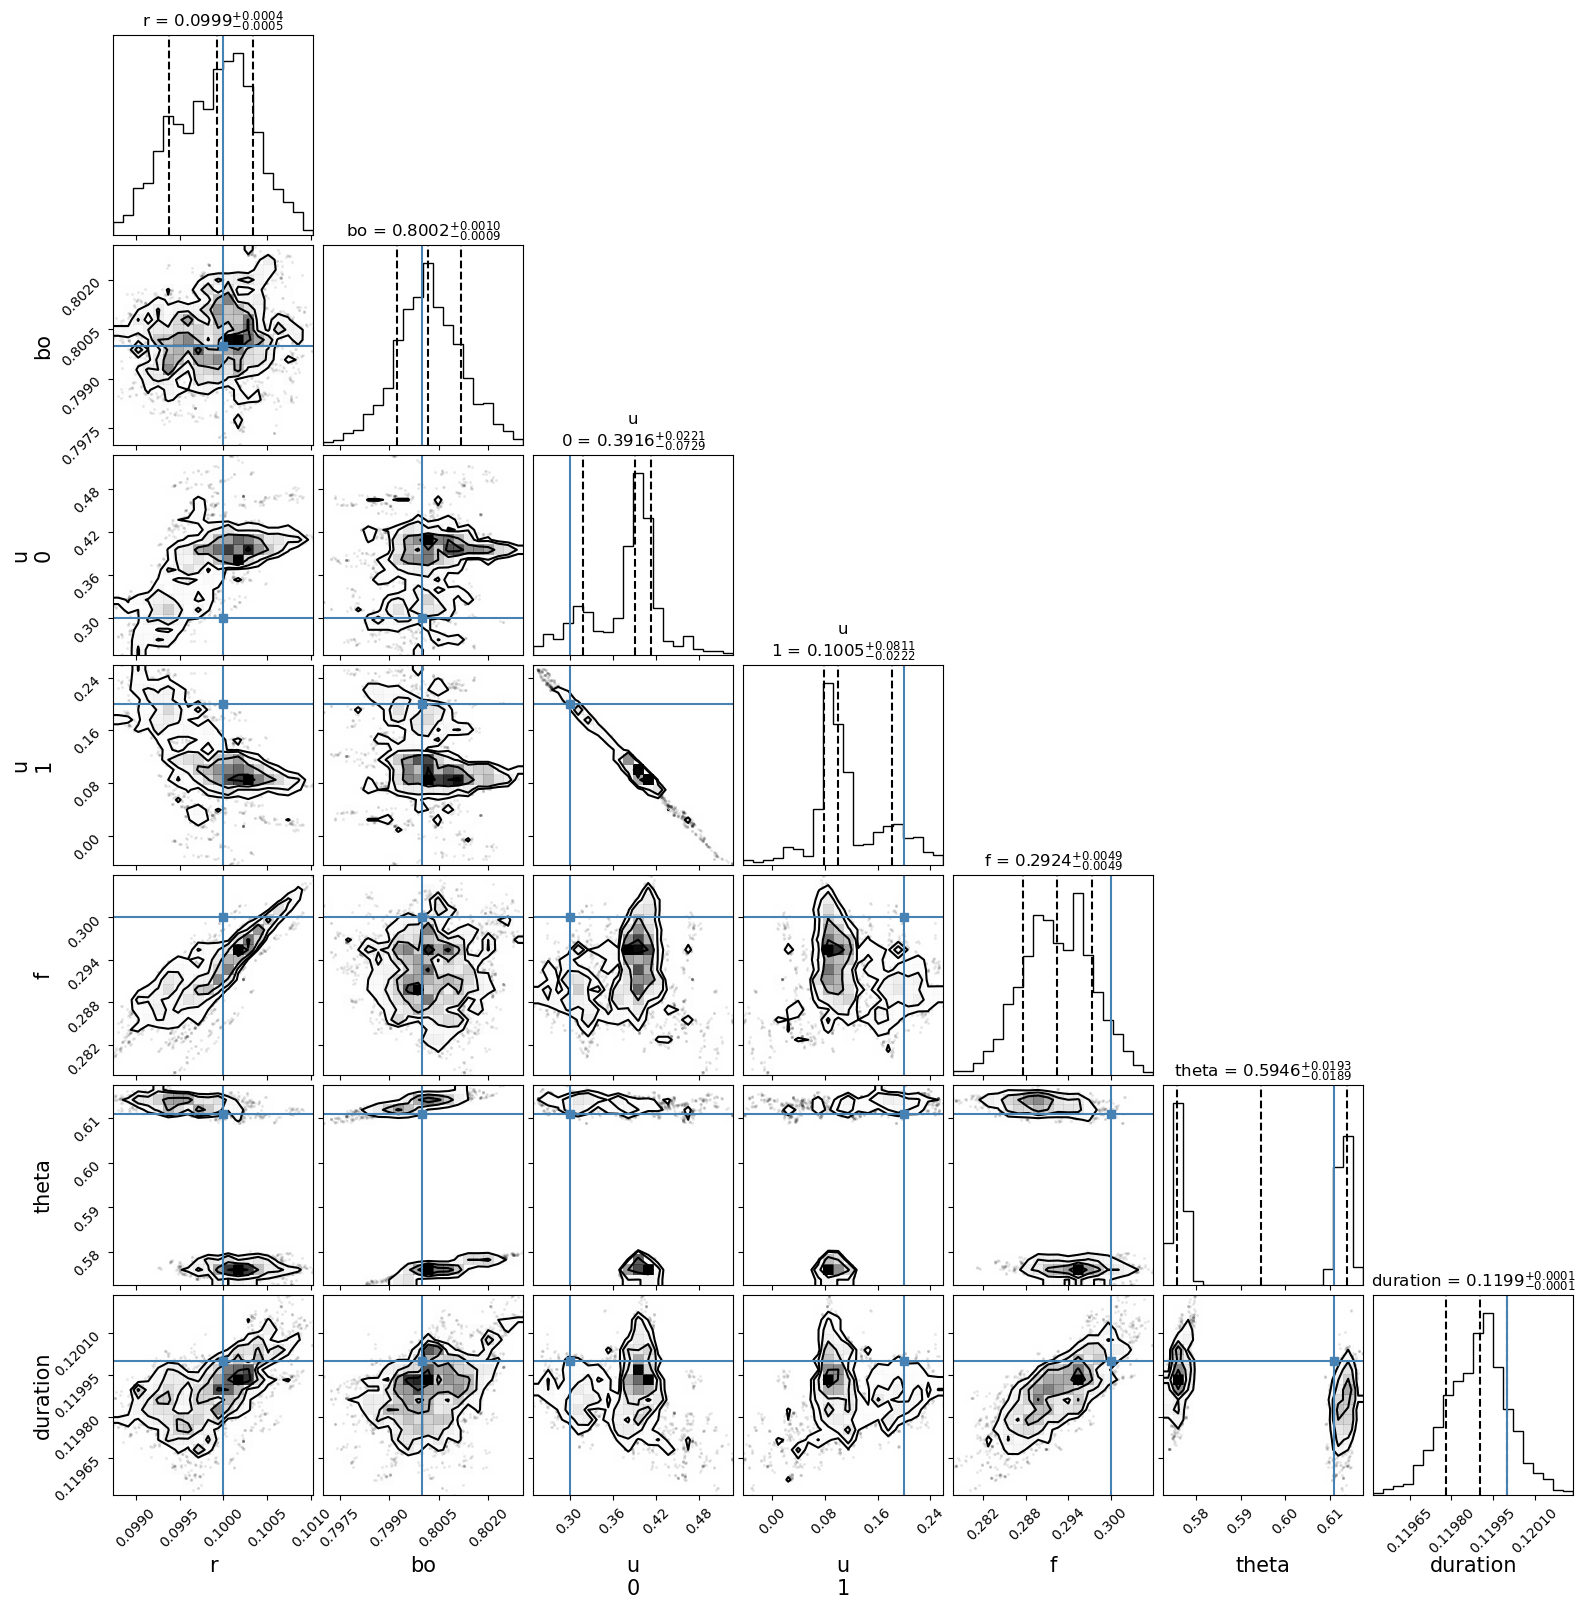

In [33]:
corner.corner(
    inf_data_wn,
    var_names=['r', 'bo', 'u', 'f', 'theta', 'duration'],
    truths=[true_params['radius'], true_params['bo'], true_params['u'][0], true_params['u'][1], true_params['f'], true_params['theta'], true_params['duration']],
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84],
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 15},
    title_fmt=".4f",
);

### Oblate Nested Sampling Fit

In [ ]:
from numpyro.contrib.nested_sampling import NestedSampler
from jaxns.prior_transforms.prior import UniformBase

In [ ]:
ns = NestedSampler(model)
ns.run(jax.random.PRNGKey(2), t, yerr, lc)

ns_samples = ns.get_samples(jax.random.PRNGKey(121), num_samples=10000)

In [ ]:
inf_data = az.from_dict(ns_samples, dropna=True)
az.summary(inf_data, var_names=["log_jitter", "log_r", "u1", "u2", "bo", "f", "theta"])
